# Variational Auto-Encoders

Variational Auto-Encoders (VAEs) are a special breed of Auto-Encoders capable of generating samples from the same distribution as input by sampling the latent space. 
They typically are generative models of the form $p_\theta(x,z)$ capable of generating new samples as the input x, by sampling the latent distribution z.

The approximate posterior refers to $q_\phi(z|x)$ probability distribution returned by the encoder part of the VAE. It tells us the probability of obtaining a latent state z given x as input to the distribution. Here x is the input to the encoder, z is the latent space variable sampled and $\phi$ denotes the network parameters of the encoder.

The prior refers to $p(z)$ probability distribution function from which z is directly sampled from.

Finally we use the decoder to model the likelihood distribution $p_\theta(x|z)$ to output reconstructed x given its latent space representation z.



## Training a Variational Autoencoder on MNIST

### Activation functions for approximate posterior and likelihood

For the approximate posterior $q_\phi(z|x)$, for mean we use no activation function to give freedom and exponential function for standard deviation in order to maintain it as positive (since input to Normal distribution is mean and variance, of which latter is always positive). For the decoder or likelihood part of VAE, since we know that our normalized output pixel values and location coordinates of the pedestrians range from 0 to 1 and -1 to 1 respectively, we use a tanh function for the output mean. For the standard deviation we train as a seperate parameter independent of the input and multiply the square of it (again to ensure that the ultimate input variance to the gaussian  distribution $p_\theta(x|z)$ is positive) with torch.one_like(mu), to ensure a diagonal covariance matrix structure. 

### Good Reconstruction but bad Generation?

Ans) The above phenomenon implies that the latent space generated by the encoder is not uniform enough for it to support generative tasks upon random sampling. This happens when distribution $q_\phi(z|x)$ has mean and variance too far from ideal sampling distribution $N(0,1)$, i.e when we don't minimize the kl-divergence between these two distributions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 


In [44]:
batch_size_train = 128
batch_size_test = 64

train_loader = torch.utils.data.DataLoader( 
    torchvision.datasets.MNIST('./datasets/', train=True, download=False,
                               transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                               ])), batch_size = batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./datasets/', train=False, download=False,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor()
                                ])), batch_size = batch_size_test, shuffle=False)  
                           

### Plotting latent representation, reconstructed and generated digits 

Trained the VAE (on training set) and done the following experiments (on test set) after the 1st epoch, the 5th
epoch, the 25th epoch, the 50th epoch, and after the optimisation converged

In [2]:
%load_ext autoreload
%autoreload 2
from vae import VAE
from train import train
from plot_utils import *

input_dims = 784
vae = VAE(input_dims=784, hidden_dims=256, latent_dims=2).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [46]:

print("Training VAE for num_epochs=1 ...")
vae_1, loss_vals_1 = train(num_epochs=1, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, vae=vae, verbose=False)
print("Training VAE for num_epochs=5 ...")
vae_5, loss_vals_5 = train(num_epochs=4, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, vae=vae_1, verbose=False)
print("Training VAE for num_epochs=25 ...")
vae_25, loss_vals_25 = train(num_epochs=20, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, vae=vae_5, verbose=False)
print("Training VAE for num_epochs=50 ...")
vae_50, loss_vals_50= train(num_epochs=25, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, vae=vae_25, verbose=False)

print("Training VAE for num_epochs=80 (converged)...")
vae_80, loss_vals_80 = train(num_epochs=30, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, vae=vae_50)

loss_vals_2dim = loss_vals_1 + loss_vals_5 + loss_vals_25 + loss_vals_50 + loss_vals_80


Training VAE for num_epochs=1 ...
Training VAE for num_epochs=5 ...
Training VAE for num_epochs=25 ...
Training VAE for num_epochs=50 ...
Training VAE for num_epochs=80 (converged)...
Epoch : 10, Train Loss Value: -75035.00386810303, Val Loss Value:-19473.64038848877, KL Div value:1189.6738424301147
Epoch : 20, Train Loss Value: -76140.50721740723, Val Loss Value:-31785.052185058594, KL Div value:1301.3995819091797
Epoch : 30, Train Loss Value: -77135.86563873291, Val Loss Value:-27274.852127075195, KL Div value:1290.474012374878


#### After 1 epoch

Z-space scatter plot


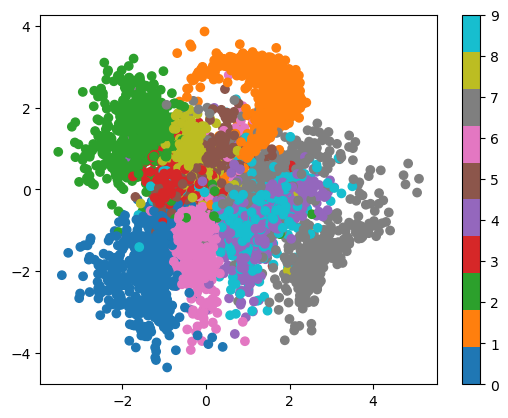

Upper row represents the original image and below is its reconstruction


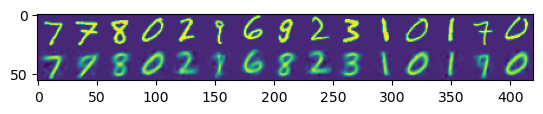

Generated Images


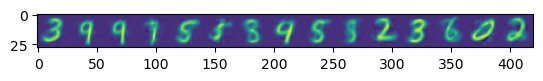

In [47]:
plot_latent_MNIST(vae_1, test_loader)
plot_reconstructed_MNIST(vae_1, test_loader)
plot_generated_MNIST(vae_1, test_loader)

#### After 5 epochs

Z-space scatter plot


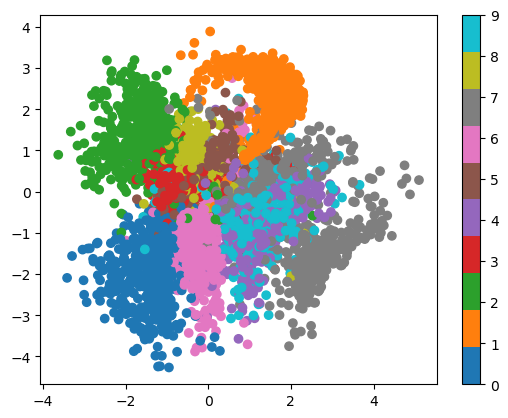

Upper row represents the original image and below is its reconstruction


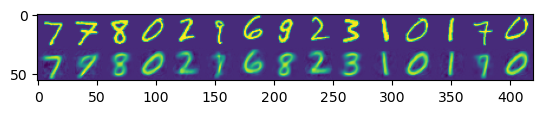

Generated Images


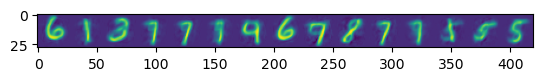

In [48]:
plot_latent_MNIST(vae_5, test_loader)
plot_reconstructed_MNIST(vae_5, test_loader)
plot_generated_MNIST(vae_5, test_loader)

#### After 25 epochs

Z-space scatter plot


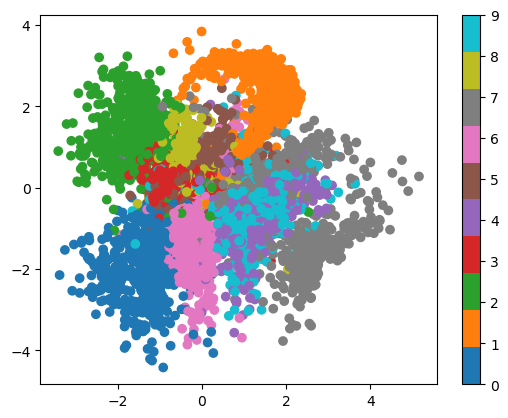

Upper row represents the original image and below is its reconstruction


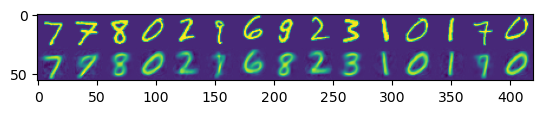

Generated Images


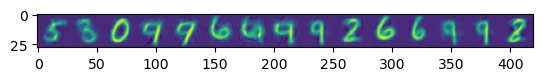

In [49]:
plot_latent_MNIST(vae_25, test_loader)
plot_reconstructed_MNIST(vae_25, test_loader)
plot_generated_MNIST(vae_25, test_loader)

#### After 50 epochs

Z-space scatter plot


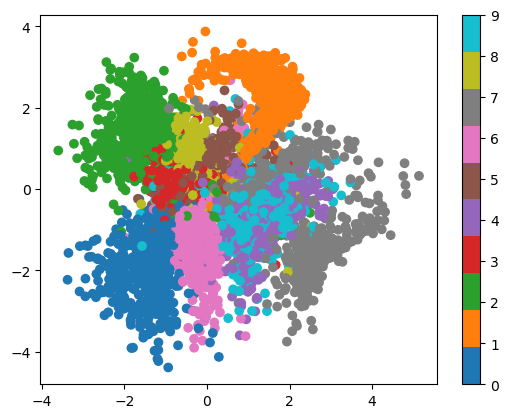

Upper row represents the original image and below is its reconstruction


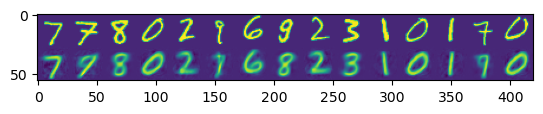

Generated Images


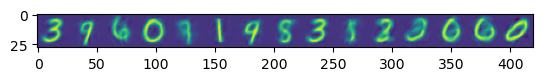

In [50]:
plot_latent_MNIST(vae_50, test_loader)
plot_reconstructed_MNIST(vae_50, test_loader)
plot_generated_MNIST(vae_50, test_loader)

#### After converged optimization (~80 epochs)

Z-space scatter plot


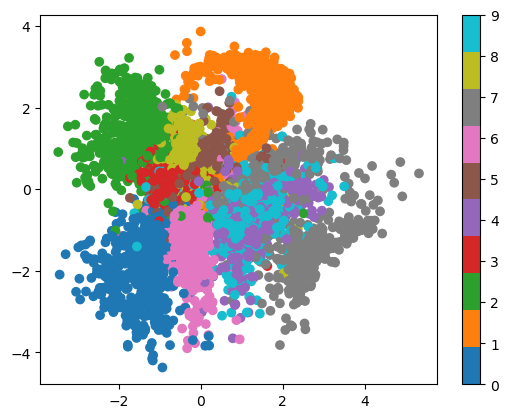

Upper row represents the original image and below is its reconstruction


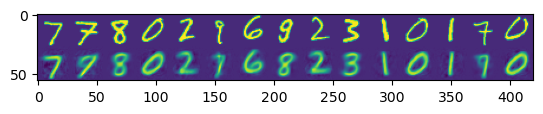

Generated Images


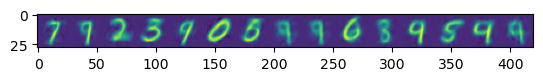

In [51]:
plot_latent_MNIST(vae_80, test_loader)
plot_reconstructed_MNIST(vae_80, test_loader)
plot_generated_MNIST(vae_80, test_loader)

### Train the VAE using a 32-dimensional latent space

In [52]:
vae_32z = VAE(input_dims=784, hidden_dims=256, latent_dims=32, encoder_layers=1, decoder_layers=1)
optimizer = torch.optim.Adam(vae_32z.parameters(), lr=1e-3)
vae_32z, loss_vals_32dim = train(num_epochs=80, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, vae=vae_32z,verbose=True, print_every_epochs=10)

Epoch : 10, Train Loss Value: -307655.2283935547, Val Loss Value:-108984.3974609375, KL Div value:12294.274337768555
Epoch : 20, Train Loss Value: -323375.10791015625, Val Loss Value:-104992.5234375, KL Div value:13123.888153076172
Epoch : 30, Train Loss Value: -330397.32360839844, Val Loss Value:-109793.94775390625, KL Div value:13056.168487548828
Epoch : 40, Train Loss Value: -334730.0862426758, Val Loss Value:-114204.24011230469, KL Div value:13096.800765991211
Epoch : 50, Train Loss Value: -337438.53869628906, Val Loss Value:-113252.10815429688, KL Div value:13491.19091796875
Epoch : 60, Train Loss Value: -339608.6752319336, Val Loss Value:-115516.70129394531, KL Div value:13768.54736328125
Epoch : 70, Train Loss Value: -341040.37103271484, Val Loss Value:-113158.53533935547, KL Div value:13588.443908691406
Epoch : 80, Train Loss Value: -342061.5316772461, Val Loss Value:-117339.76678466797, KL Div value:13660.645797729492


#### Comparing 15 generated digits with the results attained for 2-dimensional latent 

Upper row represents the original image and below is its reconstruction


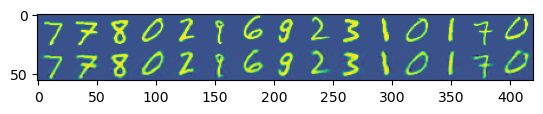

Generated digits for 32-dim latent space
Generated Images


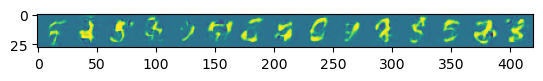

Generated digits for 2-dim latent space
Generated Images


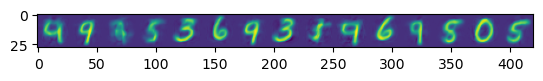

In [54]:
plot_reconstructed_MNIST(vae_32z, test_loader)
print("Generated digits for 32-dim latent space")
plot_generated_MNIST(vae_32z, test_loader)
print("Generated digits for 2-dim latent space")
plot_generated_MNIST(vae_80, test_loader)

The 32 dimensional VAE reconstructs the digits better but is worse at generation than the 2 dimensional VAE.

Curse of dimensionality : In a high dimensional space the encoding of data in latent space is scattered away, and sampling may not really result in sensible generated digits. However a more complex representation and senseful generation is possible if the network is denser and more representative. Increasing the number of layers should aleviate this problem. 





In [55]:
vae_32z_dense = VAE(input_dims=784, hidden_dims=256, latent_dims=32, encoder_layers=3, decoder_layers=3)
optimizer = torch.optim.Adam(vae_32z_dense.parameters(), lr=1e-3)
vae_32z_dense, loss_vals_32dim_dense = train(num_epochs=80, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, vae=vae_32z_dense,verbose=True, print_every_epochs=10)

Epoch : 10, Train Loss Value: -158456.17013549805, Val Loss Value:-52936.654235839844, KL Div value:3499.7876739501953
Epoch : 20, Train Loss Value: -197668.0107421875, Val Loss Value:-71179.04559326172, KL Div value:4218.586837768555
Epoch : 30, Train Loss Value: -215641.5110168457, Val Loss Value:-78494.20297241211, KL Div value:4648.140943527222
Epoch : 40, Train Loss Value: -228407.75149536133, Val Loss Value:-82092.3564453125, KL Div value:5100.775146484375
Epoch : 50, Train Loss Value: -239035.31274414062, Val Loss Value:-86351.12316894531, KL Div value:5468.753479003906
Epoch : 60, Train Loss Value: -249360.56774902344, Val Loss Value:-83830.87915039062, KL Div value:5946.075546264648
Epoch : 70, Train Loss Value: -257104.26077270508, Val Loss Value:-84154.53125, KL Div value:6180.513084411621
Epoch : 80, Train Loss Value: -262940.58267211914, Val Loss Value:-82834.08654785156, KL Div value:6575.874664306641


Generated digits for 32-dim latent space
Generated Images


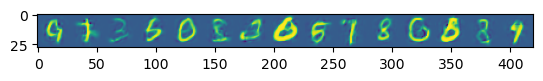

In [57]:
print("Generated digits for 32-dim latent space")
plot_generated_MNIST(vae_32z_dense, test_loader)

The reconstruction is already much better for a denser network of 3 encoder and 3 decoder layers! 

#### Loss Curve Comparison
Between that of 32-dim latent space and 2-dim latent space 

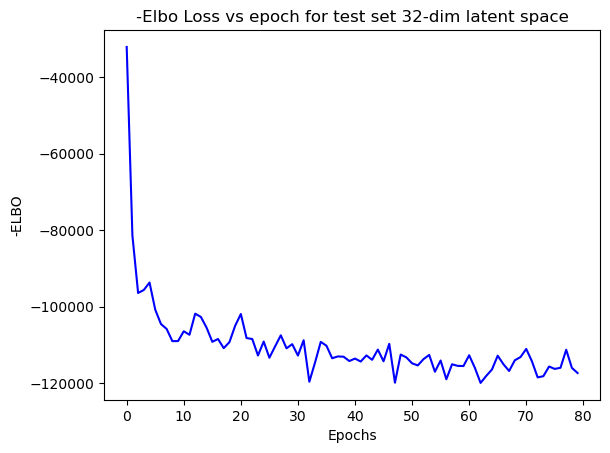

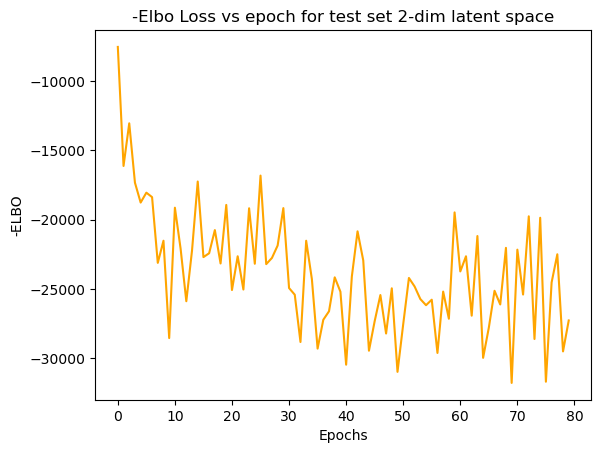

In [58]:
plt.plot(range(len(loss_vals_32dim)), loss_vals_32dim, color="blue")
plt.xlabel("Epochs")
plt.ylabel("-ELBO")
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("-Elbo Loss vs epoch for test set 32-dim latent space")
plt.show()

plt.plot(range(len(loss_vals_2dim)), loss_vals_2dim, color="orange")
plt.xlabel("Epochs")
plt.ylabel("-ELBO")
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("-Elbo Loss vs epoch for test set 2-dim latent space")
plt.show()

The 32-dim loss curve goes to much lower values with lesser fluctuations as opposed to that at latent space dimension 2

## Fire Evacuation Planning for the MI Building
Due to the increasing amount of students at the Technical University of Munich, the fire evacuation plan
for the MI building needs to be reconsidered. An important information is the distribution of people within the
MI building p(x).
In a hypothetical scenario, the fire department decided to track 100 random students and employees during
the busiest hour on different days. The idea is to use this data for learning p(x). As a first experiment, the
fire department wants to estimate the number of people that is critical for the building. To simplify the task,
it defined a sensitive area in front of the main entrance—marked by the orange rectangle (130/70 & 150/50)—
where the number of people should not exceed 100. You will get points for this task if you document the
experiments

### Scatter plot Visualization

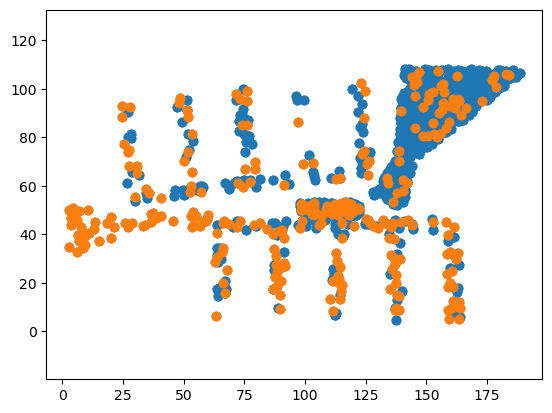

In [3]:
import numpy as np
ped_train_array = np.load('./FireEvac_train_set.npy')
ped_test_array = np.load('./FireEvac_test_set.npy')
plt.scatter(ped_train_array[:,0], ped_train_array[:,1], cmap='tab2')
plt.scatter(ped_test_array[:,0], ped_test_array[:,1], cmap='tab2')
plt.axis('equal')
plt.show()

In [4]:
## Defining custom dataset classes and dataloaders for training and testing

class Ped_Locs(torch.utils.data.Dataset):
    def __init__(self, data_array_path, data_mean, data_max) -> None:
        super().__init__()
        self.data_array = torch.from_numpy(np.load(data_array_path)).to(device)
        #self.data_array_1 = self.data_array - self.data_array.mean(axis=0)
        self.data_array_1 = self.data_array - torch.from_numpy(data_mean).to(device)
        #self.max_coords,_ = torch.max( torch.abs(self.data_array_1), axis=0)
        self.max_coords = torch.from_numpy(data_max).to(device)
        self.data_array_normalized = torch.stack((self.data_array_1[:,0]/self.max_coords[0], self.data_array_1[:,1]/self.max_coords[1]), axis=-1)
        self.data_array_normalized = self.data_array_normalized.unsqueeze(-1)
    def __len__(self):
        return len(self.data_array_normalized)

    def __getitem__(self, idx):
        return self.data_array_normalized[idx, ...].float(),idx

Normalized Location Data


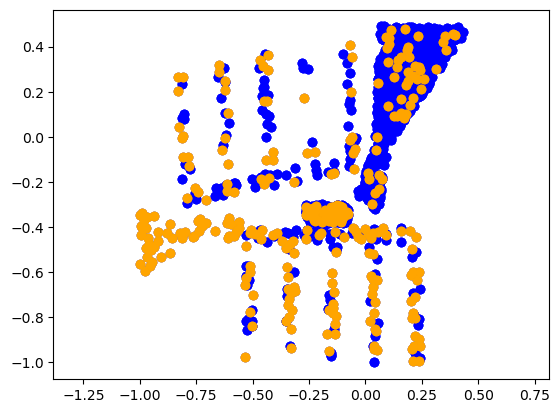

In [5]:
# Computing mean and max of the location data for normalizing it between [-1,1]
ped_loc_mean = ped_train_array.mean(axis=0)
ped_loc_max = np.max( np.abs(ped_train_array - ped_loc_mean), axis=0)  

train_ped_dataset = Ped_Locs('./FireEvac_train_set.npy', ped_loc_mean, ped_loc_max)
test_ped_dataset = Ped_Locs('./FireEvac_test_set.npy', ped_loc_mean, ped_loc_max)

train_ped_loader = torch.utils.data.DataLoader(train_ped_dataset, batch_size=16, shuffle=True)
test_ped_loader = torch.utils.data.DataLoader(test_ped_dataset, batch_size=16, shuffle=False)

print("Normalized Location Data")
for i, (data,_) in enumerate(train_ped_loader):
    data = data.squeeze(2).cpu().detach().numpy()
    plt.scatter(data[:,0], data[:,1], color='blue')
for i, (data,_) in enumerate(test_ped_loader):
    data = data.squeeze(2).cpu().detach().numpy()
    plt.scatter(data[:,0], data[:,1], color='orange')
plt.axis('equal')
plt.show() 

### Train VAE on the FireEvac data to learn $p(x)$

The model was already trained for 18000 epochs before the train cell at lr=1e-3 and thats the reason why we load it here.

Note: It is critical to save the model since training takes a lot of time for the network. As a result we have also saved the trained model for direct inference which can directly be loaded.

In [12]:
torch.save(vae_fire_evac.state_dict(), "./vae_fire_evac2.pth")

In [7]:
vae_fire_evac = VAE(input_dims=2, hidden_dims=64, latent_dims=8, encoder_layers=2, decoder_layers=2)
#vae_fire_evac.load_state_dict(torch.load('./vae_fire_evac1.pth'))
optimizer = torch.optim.Adam(vae_fire_evac.parameters(), lr=1e-3)

Training for 10000 epochs for demonstration each for lr=1e-3 and lr=1e-4 ...

In [8]:
vae_fire_evac, loss_vals = train(num_epochs=10000, train_loader= train_ped_loader,test_loader= test_ped_loader,
                        optimizer= optimizer,vae= vae_fire_evac, verbose=True, print_every_epochs=100)
optimizer = torch.optim.Adam(vae_fire_evac.parameters(), lr=1e-4)
vae_fire_evac, loss_vals = train(num_epochs=10000, train_loader= train_ped_loader,test_loader= test_ped_loader,
                        optimizer= optimizer,vae= vae_fire_evac, verbose=True, print_every_epochs=100)

Epoch : 100, Train Loss Value: -48.99730837345123, Val Loss Value:-22.032483339309692, KL Div value:76.24942827224731
Epoch : 200, Train Loss Value: -59.71211385726929, Val Loss Value:-36.04889631271362, KL Div value:77.94416522979736
Epoch : 300, Train Loss Value: -73.36183607578278, Val Loss Value:-2.62422251701355, KL Div value:115.05457305908203
Epoch : 400, Train Loss Value: -73.36318826675415, Val Loss Value:20.98761224746704, KL Div value:143.4971513748169
Epoch : 500, Train Loss Value: -90.0826506614685, Val Loss Value:21.676142930984497, KL Div value:153.88366317749023
Epoch : 600, Train Loss Value: -78.74814677238464, Val Loss Value:-33.46676206588745, KL Div value:109.3655138015747
Epoch : 700, Train Loss Value: -86.71296262741089, Val Loss Value:-10.857991695404053, KL Div value:126.09863471984863
Epoch : 800, Train Loss Value: -87.46478033065796, Val Loss Value:-11.162321090698242, KL Div value:122.43412017822266
Epoch : 900, Train Loss Value: -87.6569938659668, Val Loss V

Further training the network using lr=5e-5 for 10000 epochs

In [15]:
vae_fire_evac = VAE(input_dims=2, hidden_dims=64, latent_dims=8, encoder_layers=2, decoder_layers=2)
vae_fire_evac.load_state_dict(torch.load('./vae_fire_evac2.pth'))
optimizer = torch.optim.Adam(vae_fire_evac.parameters(), lr=5e-5)
vae_fire_evac, loss_vals = train(num_epochs=10000, train_loader= train_ped_loader,test_loader= test_ped_loader,
                        optimizer= optimizer,vae= vae_fire_evac, verbose=True, print_every_epochs=200)

Epoch : 200, Train Loss Value: -136.90561079978943, Val Loss Value:-15.737138748168945, KL Div value:180.93777465820312
Epoch : 400, Train Loss Value: -134.42403292655945, Val Loss Value:-20.82633399963379, KL Div value:178.94847297668457
Epoch : 600, Train Loss Value: -143.35437750816345, Val Loss Value:-19.649004459381104, KL Div value:177.5747013092041
Epoch : 800, Train Loss Value: -144.15014123916626, Val Loss Value:-38.09729027748108, KL Div value:158.72881031036377
Epoch : 1000, Train Loss Value: -138.92643904685974, Val Loss Value:-54.764562129974365, KL Div value:149.5455174446106
Epoch : 1200, Train Loss Value: -137.6171679496765, Val Loss Value:-42.37956666946411, KL Div value:162.8841905593872
Epoch : 1400, Train Loss Value: -134.29266476631165, Val Loss Value:-17.28360414505005, KL Div value:184.6168212890625
Epoch : 1600, Train Loss Value: -138.3498194217682, Val Loss Value:-23.68607449531555, KL Div value:179.5949878692627
Epoch : 1800, Train Loss Value: -137.77228879928

### Scatter plot of reconstructed set

Actual Points


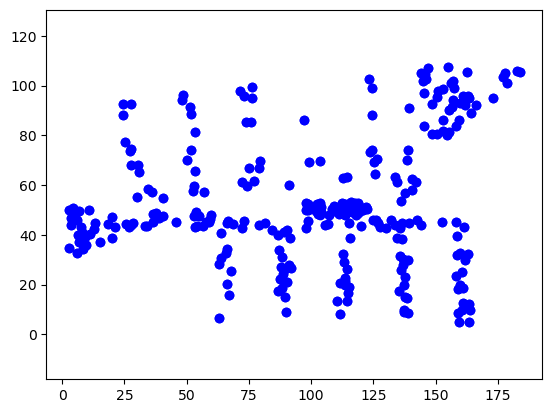

Reconstructed Points


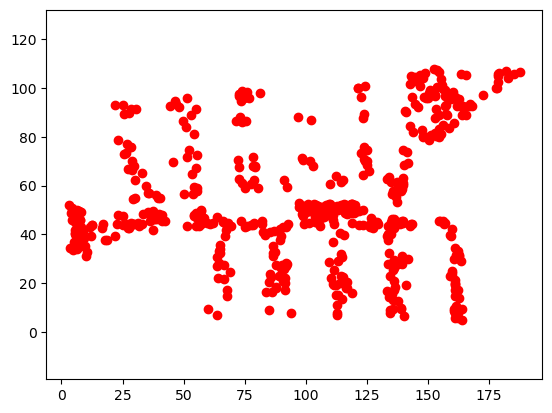

In [16]:
plot_reconstructed_ped_dist(vae_fire_evac, test_ped_loader, ped_loc_mean, ped_loc_max)

So the reconstruction looks really good!

Hopefully we'll be able to also generate meaningful distributions on random sampling!

### Scatter plot of 1000 generated samples

Generated pedestrian map


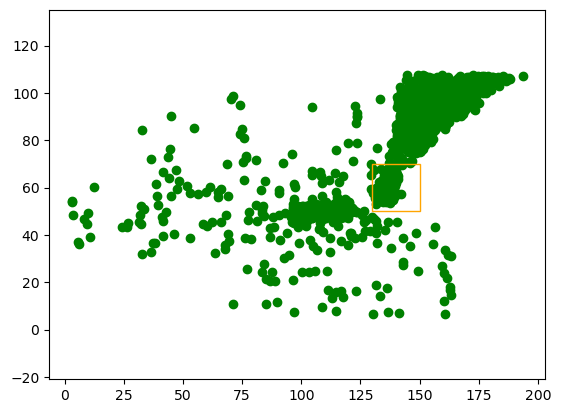

No of pedestrians  in critical area: 89


(89,
 array([[139.64992 ,  64.26469 ],
        [119.68304 ,  52.337914],
        [148.38783 ,  98.17757 ],
        ...,
        [111.18355 ,  50.970974],
        [141.63446 ,  90.100586],
        [175.60915 , 103.96911 ]], dtype=float32))

In [17]:
print("Generated pedestrian map")
plot_generated_ped_dist(vae_fire_evac, ped_loc_mean, ped_loc_max, n=1000)

### Samples needed approximately to exceed the critical numbers at marked entrance 

Here we estimate approximately the number of pedestrians in the entire building such that we reach the critical number of pedestrians at the entrance.

We take a number of sample runs for each pedestrian number ranging from 1000 to 1200 (completely heuristic) here and average the number of pedestrians reached at entrance for each them to report a good estimate.

In [21]:
num_samples = 1000
critical_ped_dict = {}
num_peds_start = 1000
num_peds_end = 1200
critical_peds = 100
for num_peds in range(num_peds_start, num_peds_end, 2):
    count = 0
    for sample in range(num_samples):
        count += plot_generated_ped_dist(vae_fire_evac, ped_loc_mean, ped_loc_max, n=num_peds, plot=False)[0]
    avg_count = count/num_samples
    critical_ped_dict[num_peds] = avg_count

print("Critical Pedestrians reached for the following Number of Pedestrians:")
for i in range(1000, 1200,2):
    print(f"No.of Pedestrians : {i}, Number of Persons in critical Area : {critical_ped_dict[i]}") 

Critical Pedestrians reached for the following Number of Pedestrians:
No.of Pedestrians : 1000, Number of Persons in critical Area : 87.05
No.of Pedestrians : 1002, Number of Persons in critical Area : 87.947
No.of Pedestrians : 1004, Number of Persons in critical Area : 87.489
No.of Pedestrians : 1006, Number of Persons in critical Area : 87.634
No.of Pedestrians : 1008, Number of Persons in critical Area : 88.161
No.of Pedestrians : 1010, Number of Persons in critical Area : 88.38
No.of Pedestrians : 1012, Number of Persons in critical Area : 87.804
No.of Pedestrians : 1014, Number of Persons in critical Area : 88.437
No.of Pedestrians : 1016, Number of Persons in critical Area : 88.45
No.of Pedestrians : 1018, Number of Persons in critical Area : 88.539
No.of Pedestrians : 1020, Number of Persons in critical Area : 89.16
No.of Pedestrians : 1022, Number of Persons in critical Area : 89.446
No.of Pedestrians : 1024, Number of Persons in critical Area : 89.076
No.of Pedestrians : 1026

Here we notice that the number of people starts to reach a constant value above 100 starting 1152 number of pedestrians.

Hence number of people should be around or more than 1152 people in order to exceed people present in the critical orange area more than 100!

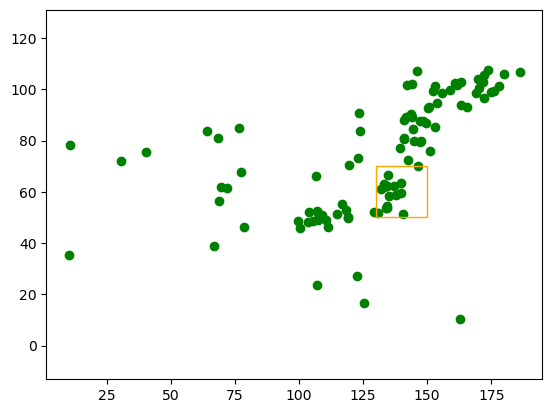

No of pedestrians  in critical area: 15


In [22]:
_, gen_points = plot_generated_ped_dist(vae_fire_evac, ped_loc_mean, ped_loc_max, n=100)
f = open('Gen Pedestrians', mode='w')
with f as open:
    for i in range(len(gen_points)):
        f.write(f"{gen_points[i,:]}\n")